# Intervention Analysis

---
Goal of the notebook: .

Inputs of the notebook:
- 

Output of the notebook:
- prediction + interpretation layer for text classification.


Takeaways: 
- .
- .

In [ ]:
# !pip install -r requirements.txt

In [32]:
import sys
sys.path.append('../../run_experiments/')
sys.path.append('../../run_experiments/scripts')
sys.path.append('../../run_experiments/models')
sys.path.append('../../run_experiments/data')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from datasets import load_dataset
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Dataset, Subset


# model for CBM
# import fonction for getting PLM and tokenizer
from models.utils import load_model_and_tokenizer

# Library for Gemma
from concepts_discovery_utils import extract_target_words, create_context_window, load_model, run_concepts_discovery
from transformers import pipeline



In [34]:
#code for autoreload script associated with jupyter notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
#Delete awkward warning
import logging
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

# 1.SETUP ENVIRONMENT VARIABLES

In [ ]:
# import config
from load_config import load_config

model_name = 'bert-base-uncased'    # 'bert-base-uncased' ou 'deberta-large' or 'gemma'
dataset    = 'agnews'               # 'movies' / 'agnews' / 'dbpedia' / 'medical'/ 'ledgar'/ n24news
annotation = 'C3M'       # 'C3M' ou 'our_annotation' ou 'combined_annotation'
config = load_config(model_name, dataset)
config.annotation = annotation

# 2. Data Loading

In [36]:
# # import the data
from prepare_data import load_fc_prepare_data
prepare_data = load_fc_prepare_data(config.DATASET)
train_loader, test_loader, val_loader, train_df, val_df, test_df = prepare_data(config)

# 3.Exp

In [38]:
import os
import torch
import torch.nn as nn
import numpy as np
from transformers import pipeline
from concepts_discovery_utils import (
    extract_target_words, create_context_window,
    load_model, run_concepts_discovery, calculate_macro_concept_frequencies,
    update_concept_frequencies, find_most_frequent_macro_concept,
    
 ) #summarize_concepts, 
from attribution_utils import (
    process_data_in_batches, get_example, example_attribution,
    split_dataloader
)
import json

# concept ranking
from sentence_transformers import SentenceTransformer

# IMPORTANT LIBRARY TO IMPORT
from TCAVS import TCAV
from TCAVS_utils import stratified_subset_dataloader

# Ranking concepts 
from ranking_utils import rank_macro_concepts, most_k_important_macro_concepts, get_concept_at_rank, randomize_scores


In [39]:
import json
def load_data_from_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [40]:
def remove_substring_and_after(string_list, substring):
    return [s.split(substring)[0] for s in string_list]

def remove_substrings(string_list, substrings_to_remove):
    return [s.replace(sub, '') for s in string_list for sub in substrings_to_remove]

def remove_leading_space(string_list):
    return [s.lstrip() for s in string_list]

def remove_end_space(string_list):
    return [s.rstrip() for s in string_list]
def remove_substring_and_after(string_list, substring):
    return [s.split(substring)[0] for s in string_list]

def remove_substrings(string_list, substrings_to_remove):
    return [s.replace(sub, '') for s in string_list for sub in substrings_to_remove]

def remove_leading_space(string_list):
    return [s.lstrip() for s in string_list]

def remove_end_space(string_list):
    return [s.rstrip() for s in string_list]

In [41]:
def get_list_concept(dataset, model_name, strategy = 'tcavs', training_mode = 'joint'):
    """
    Charge les résultats de performance depuis le fichier JSON associé à la configuration,
    filtre les itérations où les concepts sont non vides, et trace le graphique de l'importance
    de la connexion résiduelle au fil des itérations.
    
    :param config: objet de configuration contenant les attributs nécessaires (par exemple,
                   SAVE_PATH, model_name, etc.)
    """


    if model_name == 'bert-base-uncased':
        if dataset == 'movies':
            from config_movies import Config as Config_movies
            config = Config_movies()
        elif dataset =='agnews':
            from config_agnews import Config as Config_agnews 
            config = Config_agnews()
        elif dataset == 'dbpedia':
            from config_dbpedia import Config as Config_dbpedia 
            config = Config_dbpedia()
        elif dataset =='medical':
            from config_medical import Config as Config_medical
            config = Config_medical()
        else :
            print('enter a valid dataset name')
            pass

    elif model_name == 'deberta-large':
        if dataset == 'movies':
            from config_movies_deberta import Config as Config_movies
            config = Config_movies()
        elif dataset =='agnews':
            from config_agnews_deberta import Config as Config_agnews 
            config = Config_agnews()
        elif dataset == 'dbpedia':
            from config_dbpedia_deberta import Config as Config_dbpedia 
            config = Config_dbpedia()
        elif dataset =='medical':
            from config_medical_deberta import Config as Config_medical
            config = Config_medical()
        else :
            print('enter a valid dataset name')
            pass
    else :
        print('give a valid model name')


    # Construction du chemin du fichier JSON à partir de la configuration
    if strategy == 'tcavs':
        file_path = f"{config.SAVE_PATH}blue_checkpoints/{model_name}/Our_CBM_{training_mode}/{model_name}_performance_{strategy}.json"
        data = load_data_from_json(file_path)
        print(data)
    elif strategy == 'random':
        file_path = f"{config.SAVE_PATH}blue_checkpoints/{model_name}/Our_CBM_{training_mode}/{model_name}_performance_{strategy}.json"
        data = load_data_from_json(file_path)
    elif strategy == 'frequence':
        file_path = f"{config.SAVE_PATH}blue_checkpoints/{model_name}/Our_CBM_{training_mode}/{model_name}_performance_{strategy}.json"
        data = load_data_from_json(file_path)
    elif strategy == 'new_heuristique':
        file_path = f"{config.SAVE_PATH}blue_checkpoints/{model_name}/Our_CBM_{training_mode}/{model_name}_performance_{strategy}.json"
        data = load_data_from_json(file_path)
    elif strategy == 'new_heuristique_MJ':
        file_path = f"{config.SAVE_PATH}blue_checkpoints/{model_name}/Our_CBM_{training_mode}/before vacance/{model_name}_performance_{strategy}.json"
        data = load_data_from_json(file_path)
    elif strategy == 'new_heuristique_MJ_by_lig_brute':
        file_path = f"{config.SAVE_PATH}blue_checkpoints/{model_name}/Our_CBM_{training_mode}/{model_name}_performance_{strategy}.json"
        data = load_data_from_json(file_path)
    elif strategy == 'new_heuristique_MJ_our_annotation':
        file_path = f"{config.SAVE_PATH}blue_checkpoints/{model_name}/Our_CBM_{training_mode}/{model_name}_performance_{strategy}.json"
        data = load_data_from_json(file_path)
    else:
        print("select a good file")
        print(f"{config.SAVE_PATH}blue_checkpoints/{model_name}/Our_CBM_{training_mode}/{model_name}_performance_{strategy}.json")
        pass
    # Sélection des indices où la chaîne de caractères de concepts n'est pas vide
    non_empty_indices = [
        i for i, concepts in enumerate(data['concepts_discovered_by_iteration'])
        if concepts.strip()
    ]

    # Extraction des métriques en ne gardant que les itérations non vides
    filtered_data = {
        'concepts_discovered_by_iteration': [data['concepts_discovered_by_iteration'][i] for i in non_empty_indices]
    }

    # Préparation des labels pour l'axe des abscisses (concepts)
    # On garde la chaîne telle quelle ou 'empty' si la chaîne est vide (bien que le filtrage ait déjà eu lieu)
    flat_topics = [
        concepts if concepts.strip() else 'empty'
        for concepts in filtered_data['concepts_discovered_by_iteration']
    ]
    return flat_topics

In [42]:
# Listes des datasets et des modèles
datasets = ["agnews", "dbpedia", "medical", "movies"]
models = ["bert-base-uncased", "deberta-large", "roberta-large"]

concept_list  = get_list_concept("agnews", "bert-base-uncased", strategy = 'new_heuristique_MJ', training_mode = 'joint')
concept_list

['summaries of events',
 'international events',
 'Scores',
 'advancements in computing',
 'economic forecasts',
 'financial markets',
 'industry-specific terminology and jargon',
 'political developments',
 'player profiles',
 'technological trends',
 'company earnings reports',
 'charts, graphs, and financial data']

# Load CBM

In [43]:
data = concept_list
starting_concepts = concept_list
# starting_concepts = joint_residual_model.joint_model.concepts_name
# starting_concepts = starting_concepts[0:len(joint_residual_model.joint_model.concepts_name)]
n_concept_start = len(starting_concepts)
n_concept_start

12

In [44]:
from models.jointCBMv2 import JointModel

In [45]:
PATH_ModelXtoCtoY_layer

'/home/bhan/Yann_CBM/Launch/dbfs/results_agnews/blue_checkpoints/bert-base-uncased/Our_CBM_joint/before vacance/bert-base-uncased_ModelXtoCtoY_layer_state_dict_new_heuristique_MJ_0.pth'

In [46]:
PATH_embedder

'/home/bhan/Yann_CBM/Launch/dbfs/results_agnews/blue_checkpoints/bert-base-uncased/Our_CBM_joint/before vacance/bert-base-uncased_embedder_state_dict_new_heuristique_MJ_0.pth'

In [47]:
embedder_model, embedder_tokenizer, ModelXtoCtoY_layer, _ = load_model_and_tokenizer(config, n_concepts = n_concept_start)
strategy = "new_heuristique_MJ"
iteration = 0
PATH_embedder = f"{config.SAVE_PATH}blue_checkpoints/{config.model_name}/Our_CBM_joint/before vacance/{config.model_name}_embedder_state_dict_{strategy}_{iteration}.pth"
PATH_ModelXtoCtoY_layer = f"{config.SAVE_PATH}blue_checkpoints/{config.model_name}/Our_CBM_joint/before vacance/{config.model_name}_ModelXtoCtoY_layer_state_dict_{strategy}_{iteration}.pth"

embedder_model.load_state_dict(torch.load(PATH_embedder))
ModelXtoCtoY_layer.load_state_dict(torch.load(PATH_ModelXtoCtoY_layer))

embedder_model.to(device)
embedder_model.eval()

CBM_joint = JointModel(embedder_model, embedder_tokenizer, ModelXtoCtoY_layer, config, None, None)
CBM_joint.concepts_name = starting_concepts
print(".._model_.cavs.shape", len(CBM_joint.concepts_name))
print("..n_model_.classifier", CBM_joint.ModelXtoCtoY_layer)


/tmp/ipykernel_1188340/1048995267.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedder_model.load_state_dict(torch.load(PATH_embedder))


.._model_.cavs.shape 12
..n_model_.classifier End2EndModel(
  (first_model): ModelXtoC(
    (all_fc): ModuleList(
      (0-11): 12 x FC(
        (fc): Linear(in_features=768, out_features=1, bias=True)
      )
    )
  )
  (sec_model): MLP(
    (linear): Linear(in_features=12, out_features=4, bias=True)
  )
)


/tmp/ipykernel_1188340/1048995267.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ModelXtoCtoY_layer.load_state_dict(torch.load(PATH_ModelXtoCtoY_layer))


In [48]:
# charger les données de train
df_aug_train = pd.read_csv(f"{config.SAVE_PATH_CONCEPTS}/df_with_topics_v4_C3M.csv")

# adapt lines of code above to replace train_data and test_data by df_aug_train & df_aug_test
df_aug_train['text'] = df_aug_train['text'].astype(str).str.strip()

if(df_aug_train['label'].dtype != int):
    df_aug_train['label'] = df_aug_train["label"].astype(str).str.strip()
#if(df_aug_test['label'].dtype != int):
#    df_aug_test['label'] = df_aug_test["label"].astype(str).str.strip()

#dataset length
print("df_aug_train", len(df_aug_train))
print(df_aug_train['label'].unique())

# import json file
with open(f"{config.SAVE_PATH_CONCEPTS}/dictionary_{config.DATASET}.json", "r") as f:
    caption_to_number = json.load(f)

print(caption_to_number)

if(df_aug_train['label'].dtype != int):
    df_aug_train = df_aug_train[df_aug_train["label"].isin(caption_to_number.keys())]
    df_aug_train["label"] = df_aug_train["label"].map(caption_to_number)

print("df_aug_train", len(df_aug_train))
print(df_aug_train['label'].unique())


# determine total number of concepts
columns_CBM = [col for col in df_aug_train.drop(columns=['Unnamed: 0','text','label']) if 'dummy' in col]
columns_C3M = [col for col in df_aug_train.drop(columns=['Unnamed: 0','text','label']) if not 'dummy' in col]

df_aug_train 4000
[0 1 2 3]
{'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}
df_aug_train 4000
[0 1 2 3]


In [49]:
# test on C3M smaller dataset (1000 instances) for concept accuracy
df_aug_test = pd.read_csv(f"{config.SAVE_PATH_CONCEPTS}/df_with_topics_v4_test_C3M.csv")

# adapt lines of code above to replace train_data and test_data by df_aug_train & df_aug_test
df_aug_test['text'] = df_aug_test['text'].astype(str).str.strip()
if(df_aug_test['label'].dtype != int):
    df_aug_test['label'] = df_aug_test["label"].astype(str).str.strip()

#dataset length
print("df_aug_test", len(df_aug_test))
print(df_aug_test['label'].unique())

print(caption_to_number)

if(df_aug_test['label'].dtype != int):
    df_aug_test = df_aug_test[df_aug_test["label"].isin(caption_to_number.keys())]
    df_aug_test["label"] = df_aug_test["label"].map(caption_to_number)

print("df_aug_test", len(df_aug_test))
print(df_aug_test['label'].unique())

# clean column names
df_aug_test.columns = ["dummy_"+col.replace("\n", "").strip() if col in columns_C3M else col.replace("\n", "").strip() for col in df_aug_test]

# clean types to int for "missing values"
for col in [col for col in df_aug_test.columns if (df_aug_test[col].dtype == 'O') and (col !='text') and (col!='label')]:
   # df_aug_test[col] = df_aug_test[col].apply(safe_int_convert)
    df_aug_test[col] = df_aug_test[col].apply(lambda x: int(x) if str(x).isdigit() else 0)

# dataloaders
from concepts_bank_utils import create_dataloader

notre_loader_test = create_dataloader(df_aug_test, embedder_tokenizer, config.max_len, config.batch_size, shuffle=True)

CBM_joint.evaluate_model(notre_loader_test, "test", metrics_on_concepts = True)

df_aug_test 1000
[2 3 1 0]
{'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}
df_aug_test 1000
[2 3 1 0]


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.43batch/s]

Test Acc = 89.50, Test Macro F1 = 92.72
Accuracy par classe: {0: 0.9216417910447762, 1: 0.9635036496350365, 2: 0.8048780487804879, 3: 0.8656126482213439}
F1-score par classe: [0.9344992467413376, 0.976094344299319, 0.8785958301509561, 0.9197856673030337]
Moyenne des métriques des concepts : Accuracy = 85.98%, F1 = 69.43%
Métriques par concept :
summaries of events: Accuracy = 79.20%, F1 = 50.04%
international events: Accuracy = 74.50%, F1 = 74.39%
Scores: Accuracy = 61.50%, F1 = 53.30%
advancements in computing: Accuracy = 94.30%, F1 = 88.47%
economic forecasts: Accuracy = 94.80%, F1 = 52.23%
financial markets: Accuracy = 91.10%, F1 = 86.93%
industry-specific terminology and jargon: Accuracy = 92.20%, F1 = 47.97%
political developments: Accuracy = 85.10%, F1 = 83.59%
player profiles: Accuracy = 81.00%, F1 = 46.26%
technological trends: Accuracy = 91.60%, F1 = 88.89%
company earnings reports: Accuracy = 96.40%, F1 = 77.63%
charts, graphs, and financial data: Accuracy = 90.00%, F1 = 83.4

{'task_global_accuracy': 0.895,
 'task_global_macro_f1_score': 0.9272437721236616,
 'accuracies_per_class': {0: 0.9216417910447762,
  1: 0.9635036496350365,
  2: 0.8048780487804879,
  3: 0.8656126482213439},
 'f1_scores_per_class': [0.9344992467413376,
  0.976094344299319,
  0.8785958301509561,
  0.9197856673030337],
 'concept_accuracies': {'summaries of events': 0.792,
  'international events': 0.745,
  'Scores': 0.615,
  'advancements in computing': 0.943,
  'economic forecasts': 0.948,
  'financial markets': 0.911,
  'industry-specific terminology and jargon': 0.922,
  'political developments': 0.851,
  'player profiles': 0.81,
  'technological trends': 0.916,
  'company earnings reports': 0.964,
  'charts, graphs, and financial data': 0.9},
 'concept_f1_scores': {'summaries of events': 0.5003651177985319,
  'international events': 0.7439180537772088,
  'Scores': 0.5330157840664985,
  'advancements in computing': 0.8847271572705817,
  'economic forecasts': 0.5223398001175779,
  'fin

In [50]:
CBM_joint.evaluate_model(test_loader, "test", metrics_on_concepts = False)

Evaluating: 100%|██████████| 475/475 [00:16<00:00, 27.95batch/s]

Test Acc = 91.14, Test Macro F1 = 94.09
Accuracy par classe: {0: 0.9231578947368421, 1: 0.9773684210526316, 2: 0.8568421052631578, 3: 0.888421052631579}
F1-score par classe: [0.9469443451756483, 0.983531860778019, 0.9123999867831559, 0.9207662507951161]



/home/bhan/.conda/envs/good_env/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/bhan/.conda/envs/good_env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/bhan/.conda/envs/good_env/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/bhan/.conda/envs/good_env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/bhan/.conda/envs/good_env/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/bhan/.conda/envs/good_env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered 

{'task_global_accuracy': 0.9114473684210527,
 'task_global_macro_f1_score': 0.9409106108829849,
 'accuracies_per_class': {0: 0.9231578947368421,
  1: 0.9773684210526316,
  2: 0.8568421052631578,
  3: 0.888421052631579},
 'f1_scores_per_class': [0.9469443451756483,
  0.983531860778019,
  0.9123999867831559,
  0.9207662507951161],
 'concept_accuracies': {'summaries of events': nan,
  'international events': nan,
  'Scores': nan,
  'advancements in computing': nan,
  'economic forecasts': nan,
  'financial markets': nan,
  'industry-specific terminology and jargon': nan,
  'political developments': nan,
  'player profiles': nan,
  'technological trends': nan,
  'company earnings reports': nan,
  'charts, graphs, and financial data': nan},
 'concept_f1_scores': {'summaries of events': nan,
  'international events': nan,
  'Scores': nan,
  'advancements in computing': nan,
  'economic forecasts': nan,
  'financial markets': nan,
  'industry-specific terminology and jargon': nan,
  'politica

## Correction

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def manual_correct_concepts(CBM, input_ids, attention_mask, true_label, true_concepts, manual_corrections=None, minmaxconcepts=None, n_success_max=1, reduce_plots=False, verbose=True):
    """
    Permet d'intervenir manuellement sur les logits des concepts.
    Affiche un graphique comparant les logits originaux et corrigés (en barres horizontales)
    et retourne la prédiction initiale et la prédiction après correction, en combinant
    les logits avec les poids de la couche linéaire finale.
    
    Args:
        manual_corrections (dict): Dictionnaire où chaque clé est l'indice du concept et
                            la valeur à assigner (ex: {0: 0} pour mettre à zéro le logit du concept 0).
    """
    with torch.no_grad():
        # Passe avant pour récupérer les sorties
        pooled_output = CBM.get_pooled_output(input_ids, attention_mask)
        outputs = CBM.ModelXtoCtoY_layer(pooled_output)
        XtoY_output = outputs[0:1]  # Logits pour la tâche principale, shape [1, num_classes]
        XtoC_output = outputs[1:]   # Sorties des concepts, liste de tenseurs, généralement de shape [1] ou [1,1]
        pred_initial = torch.argmax(XtoY_output[0], dim=1)
    
    # XtoC_output is a list of len = n_concepts, and shape 1

    # Récupérer les logits originaux et créer une copie pour correction
    original_concepts = [x.clone() for x in XtoC_output]
    corrected_concepts = [x.clone() for x in XtoC_output]

    # get concept prediction from original concepts, if > 0 so 1, if < 0 then 0
    original_concept_predictions = [int(x.item() > 0) for x in XtoC_output]

    # Appliquer les corrections manuelles sur les concepts spécifiés
    if(manual_corrections is not None):
        if(len(manual_corrections) > 0):
            for idx, new_value in manual_corrections.items():
                if idx < len(corrected_concepts):
                    corrected_concepts[idx] = torch.full_like(corrected_concepts[idx], new_value)

    # randomly chose concept number & apply correction
    n_success = 0
    if(minmaxconcepts is not None):

        if(verbose):
            print("concept predictions vs true concepts")
            print(list(zip(concept_list,original_concept_predictions, true_concepts)))

        random_concepts = list(range(len(XtoC_output)))
        random.shuffle(random_concepts) # random.shuffle randoms in place

        for concept_number in random_concepts:

            # check if concept_prediction matches with true concept
            if original_concept_predictions[concept_number] != true_concepts[concept_number]:
                # if original concept prediction is 0, then we get max value from dict minmaxconcepts
                if original_concept_predictions[concept_number] == 0:
                    new_value = minmaxconcepts[concept_number]["max"]
                else:
                    new_value = minmaxconcepts[concept_number]["min"]
                # switch concept_prediction
                corrected_concepts[concept_number] = torch.full_like(corrected_concepts[concept_number], new_value)
                if(verbose):
                    print(f"concept {concept_number} switched from {original_concept_predictions[concept_number]}({original_concepts[concept_number].item()}) to {true_concepts[concept_number]}({corrected_concepts[concept_number].item()})")
                n_success += 1
                if(n_success >= n_success_max):
                    break
    
    # Empiler les logits pour obtenir un tenseur de forme [n_concepts]
    original_logits = torch.stack([x.squeeze() for x in original_concepts])  # shape: [n_concepts]
    corrected_logits = torch.stack([x.squeeze() for x in corrected_concepts])  # shape: [n_concepts]
    
    # Récupérer les poids de la couche linéaire appliquée sur les concepts.
    # On suppose ici que la couche linéaire finale se trouve dans CBM.ModelXtoCtoY_layer.sec_model.linear
    # et possède des poids de dimension [num_classes, n_concepts].
    classifier_weights = CBM.ModelXtoCtoY_layer.sec_model.linear.weight.detach()  # shape: [num_classes, n_concepts]

    # Calculer le produit matriciel pour obtenir la contribution par classe.
    weighted_original = classifier_weights @ original_logits.unsqueeze(1)  # shape: [num_classes, 1]
    weighted_corrected = classifier_weights @ corrected_logits.unsqueeze(1)  # shape: [num_classes, 1]

    # Combiner la sortie principale et les contributions pondérées.
    final_output_original = weighted_original.squeeze()  # shape: [num_classes]
    final_output_corrected = weighted_corrected.squeeze()  # shape: [num_classes]
    
    # Prédictions finales par argmax (indices numériques)
    pred_original = torch.argmax(final_output_original, dim=0)  # scalaire
    pred_corrected = torch.argmax(final_output_corrected, dim=0)  # scalaire
    
    if(pred_original.item()!=pred_initial.item()):
        if(verbose):
            print(f"Problem here, pred_original={pred_original.item()} != pred_initial={pred_initial.item()}")
            print(CBM_joint.embedder_tokenizer.decode(input_ids.squeeze().tolist(), skip_special_tokens=True))

    # only plot if new prediction is correct
    if(reduce_plots):
        if(pred_corrected.item() != true_label):
            return true_label, pred_original, pred_corrected
        
    if(verbose):

        # Pour le tracé, extraire les valeurs des logits des concepts (avant correction)
        concepts_original_np = original_logits.cpu().numpy()
        concepts_corrected_np = corrected_logits.cpu().numpy()
        
        # Utilisation du mapping pour afficher la caption correspondant à la prédiction
        #caption_to_number = {'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}
        number_to_caption = {v: k for k, v in caption_to_number.items()}
        
        # On affiche ici les noms de classes uniquement pour la prédiction finale
        true_caption = number_to_caption.get(true_label.item(), f"Classe {true_label.item()}")

        pred_orig_caption = number_to_caption.get(pred_original.item(), f"Classe {pred_original.item()}")
        pred_corr_caption = number_to_caption.get(pred_corrected.item(), f"Classe {pred_corrected.item()}")
        
        # Pour l'affichage des concepts, on peut conserver les noms d'origine s'ils correspondent à des
        # concepts (sinon, vous pouvez les renommer "Concept 0", "Concept 1", etc.)
        concept_names = CBM.concepts_name
        y_pos = np.arange(len(concept_names))

        # Création du graphique en barres horizontales
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.barh(y_pos - 0.2, concepts_original_np, height=0.4, color="royalblue", alpha=0.7, label="Logits originaux")
        ax.barh(y_pos + 0.2, concepts_corrected_np, height=0.4, color="tomato", alpha=0.7, label="Logits corrigés")
        
        # Affichage des valeurs sur chaque barre
        for i, v in enumerate(concepts_original_np):
            ax.text(v + 0.02, y_pos[i] - 0.2, f"{v:.2f}", color="black", va="center", fontsize=10)
        for i, v in enumerate(concepts_corrected_np):
            ax.text(v + 0.02, y_pos[i] + 0.2, f"{v:.2f}", color="black", va="center", fontsize=10)
        
        ax.set_xlabel("Valeur du logit", fontsize=12)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(concept_names, fontsize=12)
        # ax.set_title(
        #     f"Texte: {CBM.embedder_tokenizer.decode(input_ids.squeeze().tolist(), skip_special_tokens=True)}\n"
        #     f"True label: {true_caption} - Prédiction initiale: {pred_orig_caption}, après correction: {pred_corr_caption}",
        #     fontsize=14,
        #     usetex=False  # Désactive les caractères mathématiques
        # )
        import re
        
        def clean_text(text):
            # Expression régulière pour supprimer les caractères spéciaux comme $, \, #, etc.
            # On garde seulement les lettres, les chiffres, et les espaces
            return re.sub(r'[^\w\s]', '', text)
        
        # Utilisation dans ton code
        #title_text = f"Texte: {CBM.embedder_tokenizer.decode(input_ids.squeeze().tolist(), skip_special_tokens=True)}\n"
        title_text = f"True label: {true_caption} - Prédiction initiale: {pred_orig_caption}, après correction: {pred_corr_caption}"
        
        # Appliquer la fonction de nettoyage
        cleaned_title = clean_text(title_text)
        
        # Puis utiliser cette version nettoyée pour le titre du graphique
        ax.set_title(cleaned_title, fontsize=14)
        
        ax.legend(fontsize=12)
        ax.grid(axis="x", linestyle="--", alpha=0.5)
        
        plt.tight_layout()
        plt.show()
    
    return true_label, pred_original, pred_corrected

In [52]:
# calculer logits moyens quand chaque concept est activé ou non
# avoir possibilité de changer un concept en particulier quand il est mal prédit, en mettant valeur moyenne du logits pour la bonne activation
# checker si prédiction finale change dans le bon sens ou pas
# on change les concepts mal classifiés peu importe la classification finale -> il se peut que la prédiction finale était bonne et change en corrigeant un concept
# choisir un concept mal détecté aléatoirement 
# min ou max des logits pour annuler ou activer
# itération : 3 mais pas 3 mal détéctés alors on en prend 2

# se focaliser sur les texts mal classés d'abord, si ça fonctionne ensuite sur tout le text
# prendre 50 exemple et faire la main pour comparer les concepts vraiment absurdes

In [53]:
notre_loader_test = create_dataloader(df_aug_test, embedder_tokenizer, config.max_len, batch_size=1, shuffle=False)

In [54]:
# min & max logits for each concept

minmaxconcepts = {i:{"min": 0,'max':0} for i in range(len(concept_list))}

for batch in notre_loader_test:
    # On extrait le premier exemple du batch (en s'assurant qu'il a une dimension batch de 1)
    input_ids = batch["input_ids"][0].unsqueeze(0).to(CBM_joint.device)
    attention_mask = batch["attention_mask"][0].unsqueeze(0).to(CBM_joint.device)
    true_label = batch["label"][0].unsqueeze(0).to(CBM_joint.device)
    
    # Passe avant pour obtenir la prédiction initiale
    with torch.no_grad():
        pooled_output = CBM_joint.get_pooled_output(input_ids, attention_mask)
        outputs = CBM_joint.ModelXtoCtoY_layer(pooled_output)

        #XtoY_output = outputs[0:1]  # Logits de la tâche principale
        XtoC_output = outputs[1:]   # Sorties des concepts, liste de tenseurs, généralement de shape [1] ou [1,1]
        # XtoC_output is a list of len = n_concepts, and shape 1

        for iconcept in range(len(XtoC_output)):
            logits = XtoC_output[iconcept].item()
            if logits < minmaxconcepts[iconcept]['min']:
                minmaxconcepts[iconcept]['min'] = logits
            if logits > minmaxconcepts[iconcept]['max']:
                minmaxconcepts[iconcept]['max'] = logits

minmaxconcepts

{0: {'min': -2.4421164989471436, 'max': 7.506682395935059},
 1: {'min': -2.6331660747528076, 'max': 4.781730651855469},
 2: {'min': -2.004336357116699, 'max': 1.1539427042007446},
 3: {'min': -7.263266086578369, 'max': 2.0327937602996826},
 4: {'min': -6.636328220367432, 'max': 0.27220168709754944},
 5: {'min': -9.12415599822998, 'max': 7.219388961791992},
 6: {'min': 0, 'max': 5.714653491973877},
 7: {'min': -8.77308177947998, 'max': 5.927428245544434},
 8: {'min': -5.761074542999268, 'max': 0.29825520515441895},
 9: {'min': -5.529953479766846, 'max': 3.737168312072754},
 10: {'min': -9.666099548339844, 'max': 1.4621754884719849},
 11: {'min': -3.90594482421875, 'max': 3.4891960620880127}}

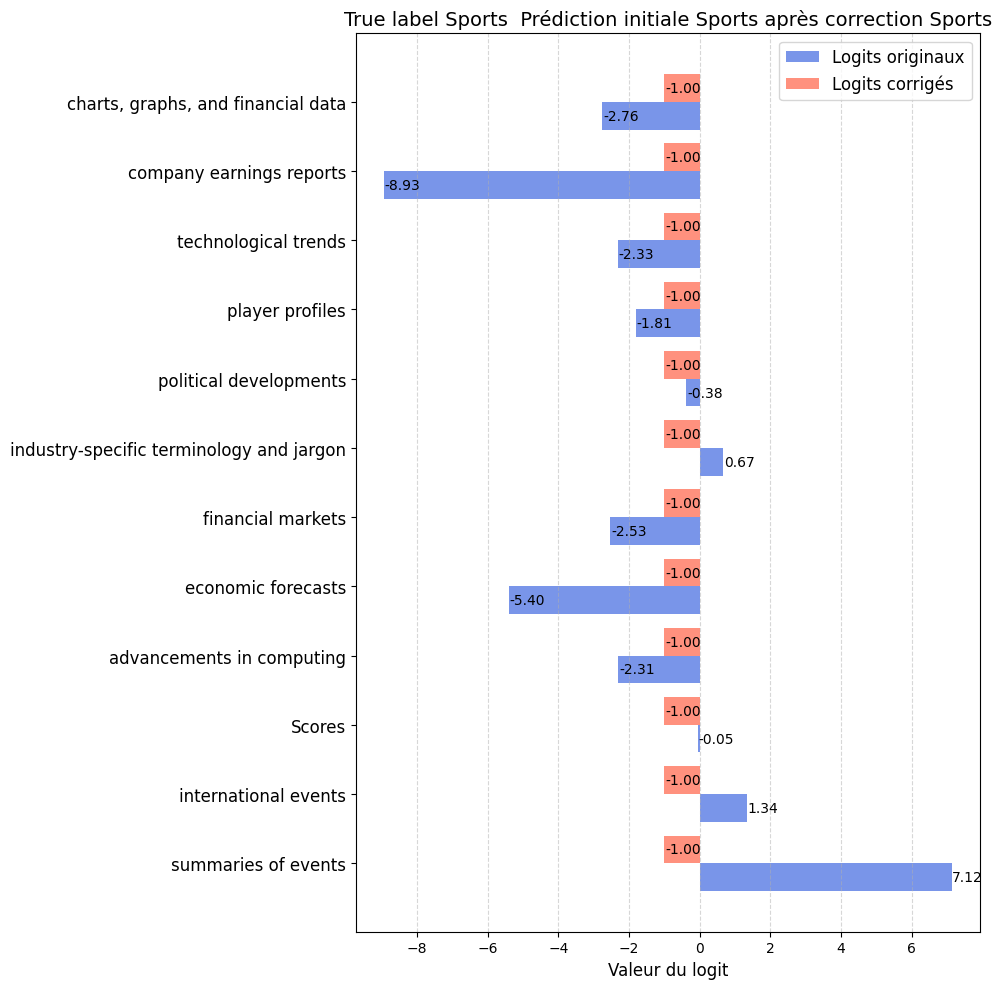

In [55]:
for ibatch,batch in enumerate(notre_loader_test):
    # On s'assure que chaque entrée est sous forme de batch (dimension 2)
    input_ids = batch["input_ids"][0].unsqueeze(0).to(CBM_joint.device)
    attention_mask = batch["attention_mask"][0].unsqueeze(0).to(CBM_joint.device)
    labels = batch['label'][0].unsqueeze(0).to(CBM_joint.device)
    # get concept labels from batch, using concept_list to get each concept name in batch
    true_concepts = [batch[concept_name][0].item() for concept_name in concept_list]
    
    # Maintenant, on peut appeler la fonction en intervenant sur le concept d'indice 1
    manual_correct_concepts(CBM_joint, input_ids, attention_mask, labels, true_concepts, manual_corrections = {0: -1, 1:-1, 2:-1, 3:-1, 4:-1, 5:-1, 6:-1, 7:-1, 8:-1, 9:-1, 10:-1, 11:-1, 12:-1, 13:-1})
    break

concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 0, 0), ('Scores', 0, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0, 0), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 0), ('player profiles', 0, 0), ('technological trends', 1, 1), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 0, 0)]


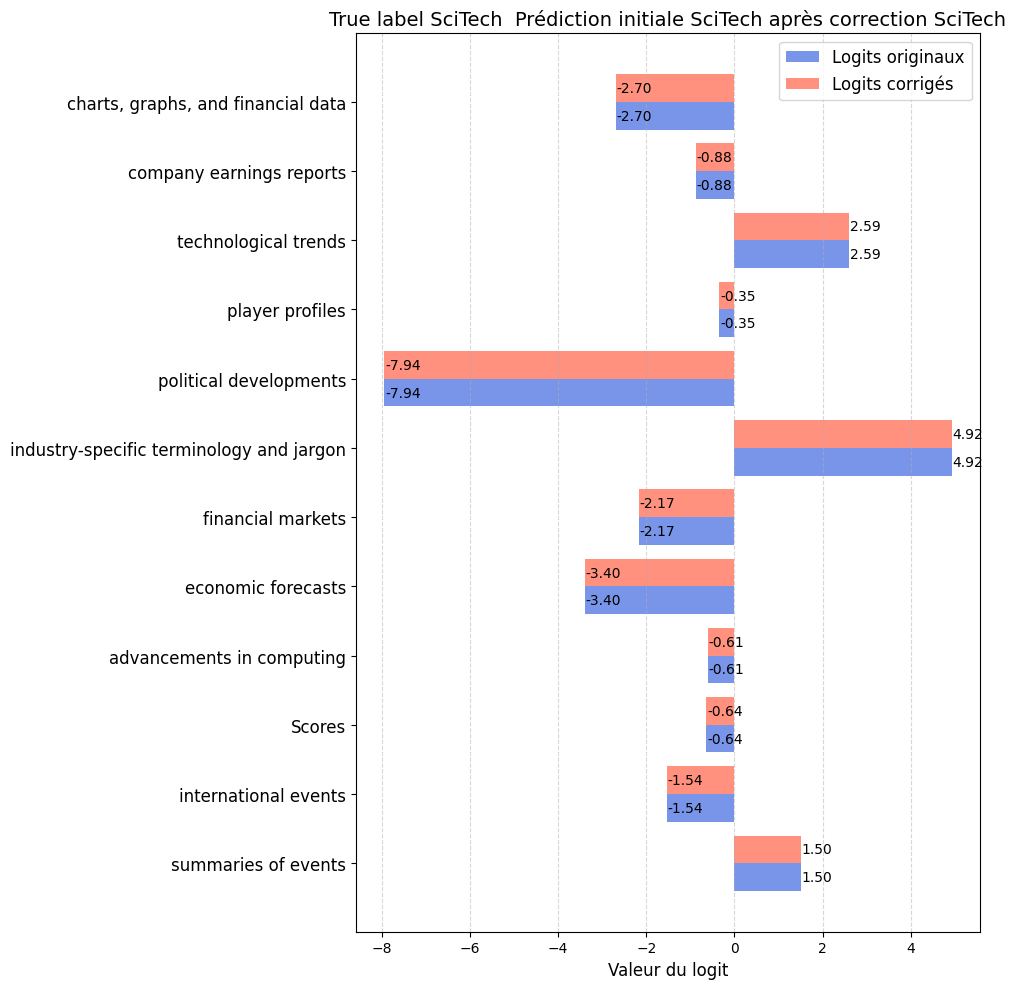

In [56]:
for ibatch,batch in enumerate(notre_loader_test):
    # On s'assure que chaque entrée est sous forme de batch (dimension 2)
    input_ids = batch["input_ids"][0].unsqueeze(0).to(CBM_joint.device)
    attention_mask = batch["attention_mask"][0].unsqueeze(0).to(CBM_joint.device)
    labels = batch['label'][0].unsqueeze(0).to(CBM_joint.device)
    # get concept labels from batch, using concept_list to get each concept name in batch
    true_concepts = [batch[concept_name][0].item() for concept_name in concept_list]
    
    # Maintenant, on peut appeler la fonction en intervenant sur le concept d'indice 1
    manual_correct_concepts(CBM_joint, input_ids, attention_mask, labels, true_concepts, minmaxconcepts = minmaxconcepts)
    break

In [57]:
import torch
import numpy as np

# --- Étape 1 : Détection des exemples mal classés ---
all_examples = []
misclassified_examples = []  # On stocke (input_ids, attention_mask, true_label) pour les exemples mal classés

# On parcourt le dataloader de train
for ibatch,batch in enumerate(notre_loader_test):
    # On extrait le premier exemple du batch (en s'assurant qu'il a une dimension batch de 1)
    input_ids = batch["input_ids"][0].unsqueeze(0).to(CBM_joint.device)
    attention_mask = batch["attention_mask"][0].unsqueeze(0).to(CBM_joint.device)
    true_label = batch["label"][0].unsqueeze(0).to(CBM_joint.device)
    true_concepts = [batch[concept_name][0].item() for concept_name in concept_list]
    
    # Passe avant pour obtenir la prédiction initiale
    with torch.no_grad():
        pooled_output = CBM_joint.get_pooled_output(input_ids, attention_mask)
        #outputs = CBM_joint.ModelXtoCtoY_layer(pooled_output)
        #XtoY_output = outputs[0:1]  # Logits de la tâche principale
        #pred_initial = torch.argmax(XtoY_output[0], dim=1)

    true_label, pred_original, pred_corrected = manual_correct_concepts(CBM_joint, input_ids, attention_mask, true_label, true_concepts, manual_corrections={}, reduce_plots=True, verbose=False)

    # Si la prédiction initiale est différente du true label, on sauvegarde l'exemple
    if pred_original.item() != true_label.item():
        misclassified_examples.append((input_ids, attention_mask, true_label, true_concepts, False))
        all_examples.append((input_ids, attention_mask, true_label, true_concepts, False))
    else:
        all_examples.append((input_ids, attention_mask, true_label, true_concepts, True))
    

In [58]:
print(f"Nombre d'exemples mal classés détectés : {len(misclassified_examples)} sur un total de {len(all_examples)} ; acc = {(len(all_examples)-len(misclassified_examples))/len(all_examples)}")

Nombre d'exemples mal classés détectés : 104 sur un total de 1000 ; acc = 0.896


In [59]:
def concept_correction(CBM_joint, examples, minmaxconcepts, n_success_max=1, verbose=True):
    # Parcours des exemples mal classés et tentative de correction
    n_total = len(examples)

    n_correct_init = 0
    n_correct_final = 0
    n_correct_to_wrong = 0
    n_wrong_to_correct = 0
    n_correct_to_correct = 0

    for ex in examples:
        input_ids, attention_mask, true_labels, true_concept_labels, correct_pred = ex
        # Affichage du texte pour le contexte
        texte = CBM_joint.embedder_tokenizer.decode(input_ids.squeeze().tolist(), skip_special_tokens=True)
        #print("\n====================================")
        #print("Texte :", texte)
        # correction manuelle
        true_label, pred_original, pred_corrected = manual_correct_concepts(CBM_joint, input_ids, attention_mask, true_labels, true_concept_labels, minmaxconcepts = minmaxconcepts, reduce_plots=True, n_success_max=n_success_max, verbose=verbose)
        
        if(correct_pred):
            n_correct_init += 1

        if(true_label.item() == pred_corrected.item()):
            if(verbose):
                print(f"Correction réussie ! Prédiction initiale: {pred_original.item()}, Prédiction corrigée: {pred_corrected.item()}")
            n_correct_final += 1
            if(pred_original.item() != true_label.item()):
                n_wrong_to_correct += 1
            else:
                n_correct_to_correct += 1
        else:
            if(verbose):
                print(f"Correction échouée ! Prédiction initiale: {pred_original.item()}, Prédiction corrigée: {pred_corrected.item()}")
            if(pred_original.item() == true_label.item()):
                n_correct_to_wrong += 1
        if(verbose):
            print("====================================")

    if(verbose):
        print(f"maximum number of concepts corrected: {n_success_max}")
        print(f"Initial accuracy: {n_correct_init/n_total*100}%")
        print(f"Nombre de corrections réussies: {n_correct_final}; final accuracy: {n_correct_final/n_total*100}%")

    return n_correct_init, n_correct_final, n_total, n_correct_to_wrong, n_wrong_to_correct, n_correct_to_correct

In [60]:
def average_concept_corrections(CBM_joint, misclassified_examples, minmaxconcepts, n_success_max=1, n_trial=10):
    n_correct_total = 0
    n_correct_to_wrong_total = 0
    n_wrong_to_correct_total = 0
    n_correct_to_correct_total = 0
    for _ in range(n_trial):
        n_correct_init, n_correct_final, n_total, n_correct_to_wrong, n_wrong_to_correct, n_correct_to_correct = concept_correction(CBM_joint, misclassified_examples, minmaxconcepts, n_success_max=n_success_max, verbose=False)
        n_correct_total += n_correct_final
        n_correct_to_wrong_total += n_correct_to_wrong
        n_wrong_to_correct_total += n_wrong_to_correct
        n_correct_to_correct_total += n_correct_to_correct

    print(f"Initial accuracy: {n_correct_init/n_total*100}%")
    print(f"Max concept corrections: {n_success_max}")
    print(f"Nombre moyen de bonnes prédictions: {n_correct_total/n_trial}; Final accuracy: {n_correct_total/(n_trial*len(misclassified_examples))*100}%")
    print(f"Nombre moyen de wrong->correct: {n_wrong_to_correct_total/n_trial}")
    print(f"Nombre moyen de correct->wrong: {n_correct_to_wrong_total/n_trial}")
    print(f"Nombre moyen de correct->correct: {n_correct_to_correct_total/n_trial}")

In [61]:
for i in range(1,6):
    average_concept_corrections(CBM_joint, misclassified_examples, minmaxconcepts, n_success_max=i, n_trial=25)

Initial accuracy: 0.0%
Max concept corrections: 1
Nombre moyen de bonnes prédictions: 11.8; Final accuracy: 11.346153846153847%
Nombre moyen de wrong->correct: 11.8
Nombre moyen de correct->wrong: 0.0
Nombre moyen de correct->correct: 0.0
Initial accuracy: 0.0%
Max concept corrections: 2
Nombre moyen de bonnes prédictions: 18.4; Final accuracy: 17.692307692307693%
Nombre moyen de wrong->correct: 18.4
Nombre moyen de correct->wrong: 0.0
Nombre moyen de correct->correct: 0.0
Initial accuracy: 0.0%
Max concept corrections: 3
Nombre moyen de bonnes prédictions: 17.64; Final accuracy: 16.96153846153846%
Nombre moyen de wrong->correct: 17.64
Nombre moyen de correct->wrong: 0.0
Nombre moyen de correct->correct: 0.0
Initial accuracy: 0.0%
Max concept corrections: 4
Nombre moyen de bonnes prédictions: 16.16; Final accuracy: 15.538461538461537%
Nombre moyen de wrong->correct: 16.16
Nombre moyen de correct->wrong: 0.0
Nombre moyen de correct->correct: 0.0
Initial accuracy: 0.0%
Max concept correc

In [62]:
for i in range(1,6):
    average_concept_corrections(CBM_joint, all_examples, minmaxconcepts, n_success_max=i, n_trial=25)

Initial accuracy: 89.60000000000001%
Max concept corrections: 1
Nombre moyen de bonnes prédictions: 806.96; Final accuracy: 80.696%
Nombre moyen de wrong->correct: 11.6
Nombre moyen de correct->wrong: 100.64
Nombre moyen de correct->correct: 795.36
Initial accuracy: 89.60000000000001%
Max concept corrections: 2
Nombre moyen de bonnes prédictions: 745.04; Final accuracy: 74.504%
Nombre moyen de wrong->correct: 18.16
Nombre moyen de correct->wrong: 169.12
Nombre moyen de correct->correct: 726.88
Initial accuracy: 89.60000000000001%
Max concept corrections: 3
Nombre moyen de bonnes prédictions: 712.04; Final accuracy: 71.20400000000001%
Nombre moyen de wrong->correct: 18.32
Nombre moyen de correct->wrong: 202.28
Nombre moyen de correct->correct: 693.72
Initial accuracy: 89.60000000000001%
Max concept corrections: 4
Nombre moyen de bonnes prédictions: 694.76; Final accuracy: 69.476%
Nombre moyen de wrong->correct: 16.32
Nombre moyen de correct->wrong: 217.56
Nombre moyen de correct->correc

concept predictions vs true concepts
[('summaries of events', 0, 1), ('international events', 1, 0), ('Scores', 1, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 1, 0), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 1), ('player profiles', 0, 0), ('technological trends', 1, 1), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 0, 1)]
concept 7 switched from 0(-4.244631767272949) to 1(5.927428245544434)
concept 5 switched from 1(0.28714415431022644) to 0(-9.12415599822998)
concept 0 switched from 0(-0.8608334064483643) to 1(7.506682395935059)
concept 1 switched from 1(0.5274437665939331) to 0(-2.6331660747528076)
concept 11 switched from 0(-1.069311261177063) to 1(3.4891960620880127)
Problem here, pred_original=2 != pred_initial=3
sap awarded \ $ 35 million postal service contract the postal service, which employs more than a third of the civilian employees of the federal government

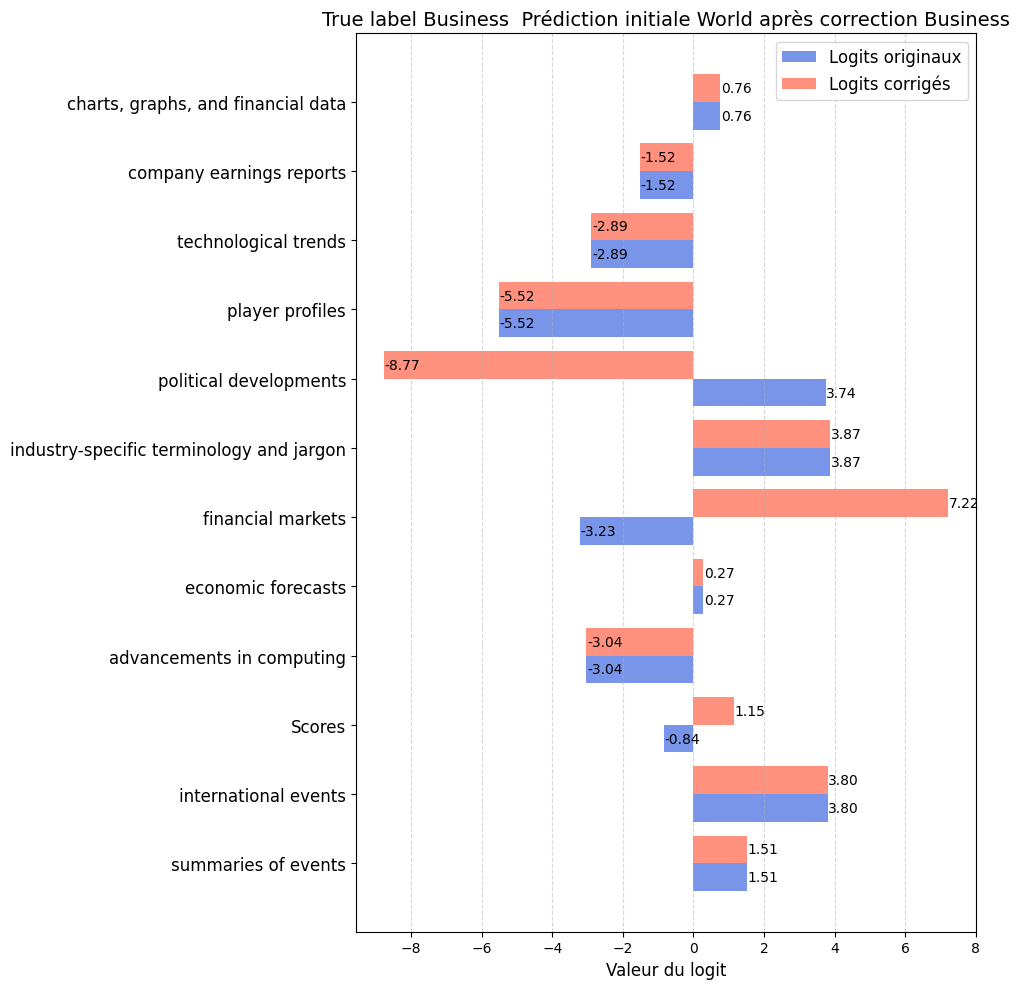

Correction réussie ! Prédiction initiale: 0, Prédiction corrigée: 2
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 1, 1), ('Scores', 0, 1), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0, 0), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 0), ('player profiles', 0, 0), ('technological trends', 0, 0), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 0, 0)]
concept 2 switched from 0(-0.257427841424942) to 1(1.1539427042007446)
Correction échouée ! Prédiction initiale: 1, Prédiction corrigée: 1
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 0, 0), ('Scores', 0, 1), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0, 0), ('industry-specific terminology and jargon', 1, 1), ('political developments', 1, 0), ('player profiles', 0, 0), ('technological trends'

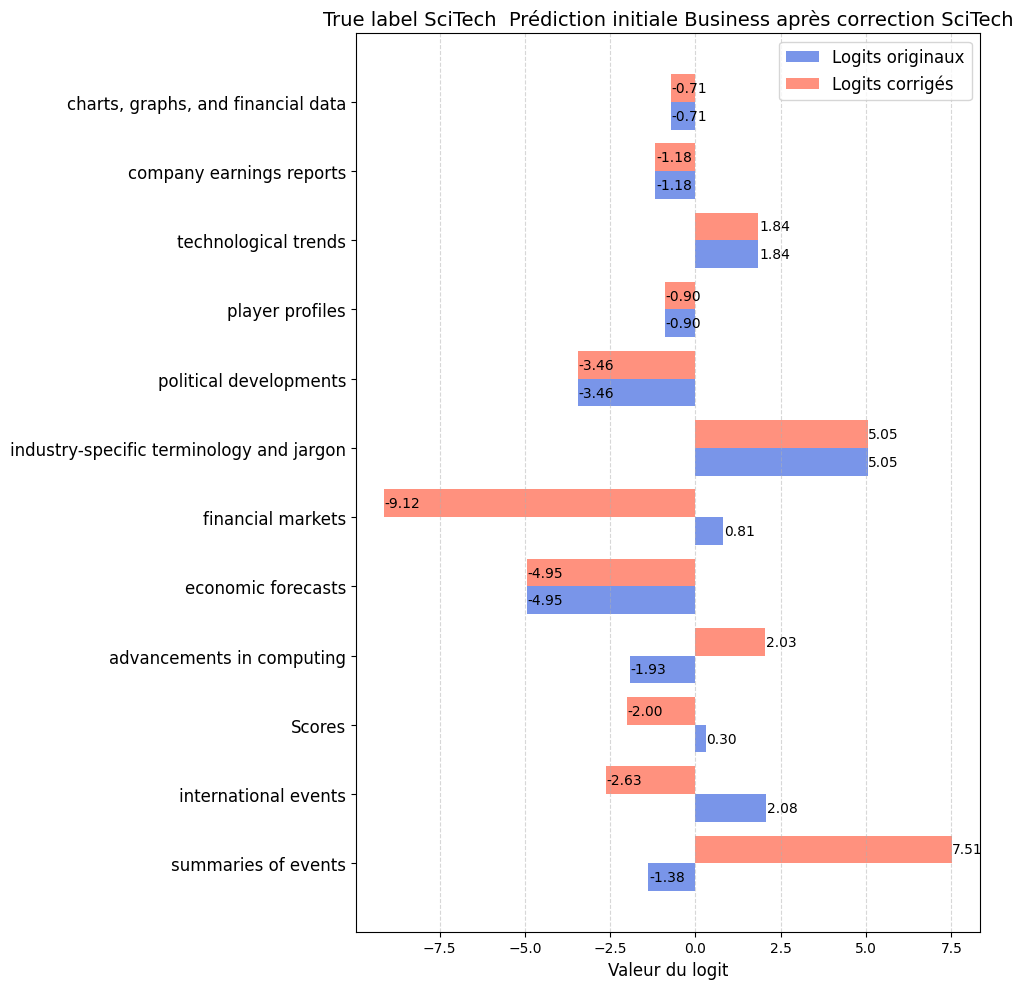

Correction réussie ! Prédiction initiale: 2, Prédiction corrigée: 3
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 1, 1), ('Scores', 0, 1), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0, 0), ('industry-specific terminology and jargon', 1, 0), ('political developments', 1, 1), ('player profiles', 0, 0), ('technological trends', 0, 0), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 0, 0)]
concept 6 switched from 1(3.0501763820648193) to 0(0.0)
concept 2 switched from 0(-0.5434113144874573) to 1(1.1539427042007446)


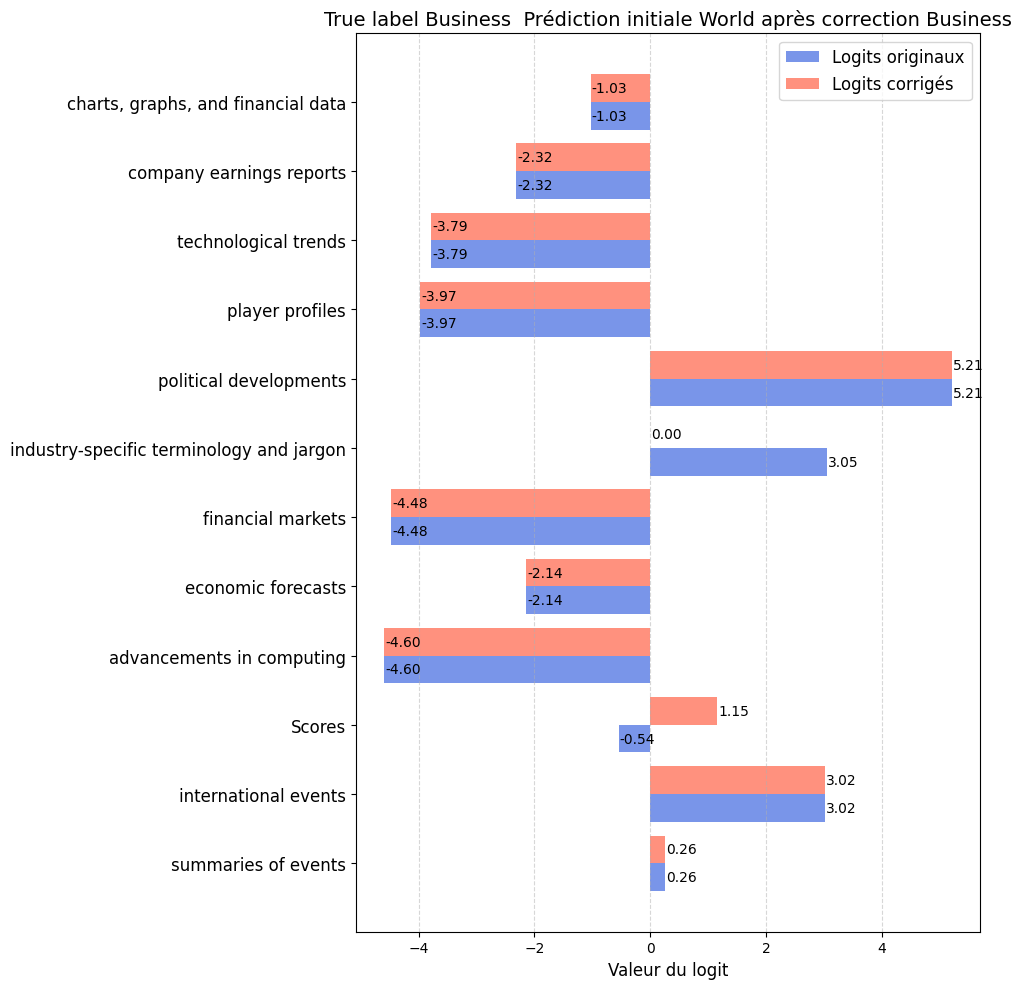

Correction réussie ! Prédiction initiale: 0, Prédiction corrigée: 2
concept predictions vs true concepts
[('summaries of events', 0, 0), ('international events', 0, 0), ('Scores', 0, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 1, 1), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 0), ('player profiles', 0, 0), ('technological trends', 1, 1), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 0, 0)]
Correction échouée ! Prédiction initiale: 3, Prédiction corrigée: 3
concept predictions vs true concepts
[('summaries of events', 0, 0), ('international events', 1, 0), ('Scores', 1, 0), ('advancements in computing', 0, 1), ('economic forecasts', 0, 0), ('financial markets', 1, 1), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 0), ('player profiles', 0, 0), ('technological trends', 1, 1), ('company earnings reports', 0, 0), ('charts, graphs, and fina

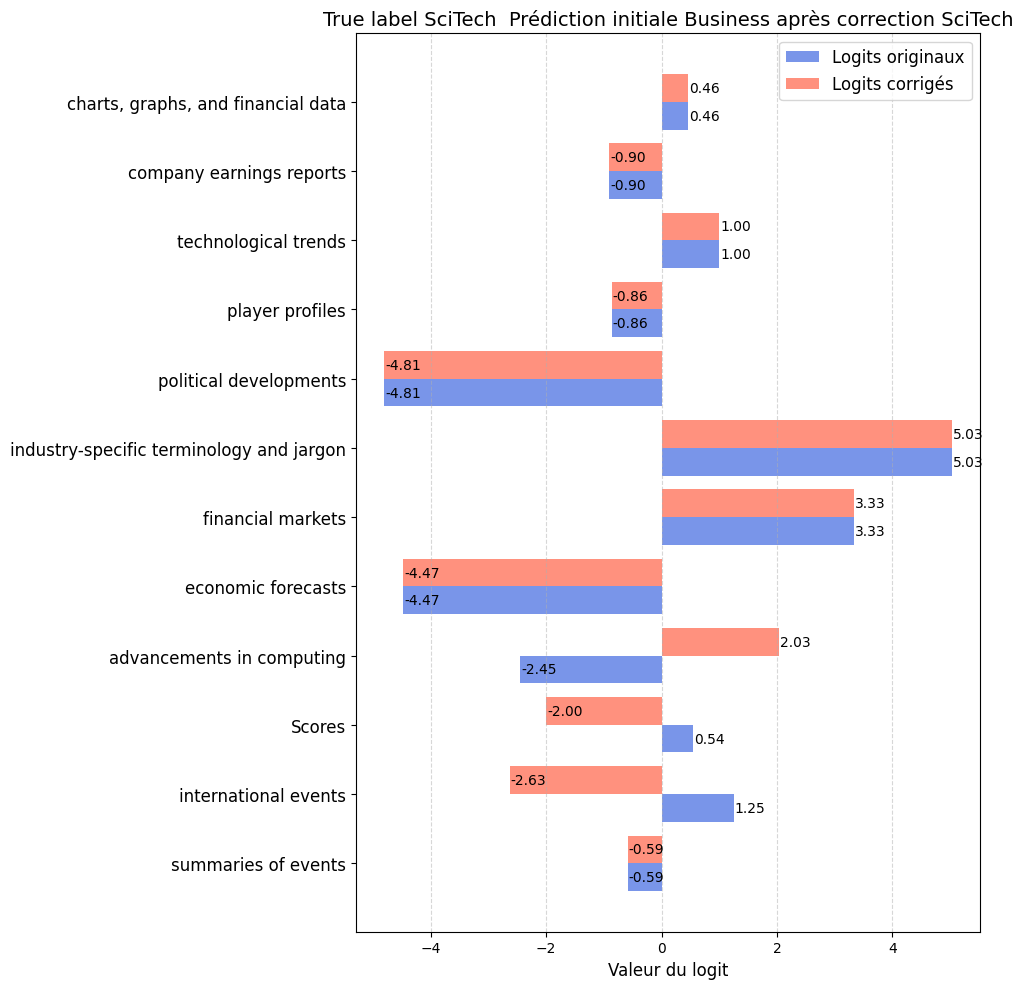

Correction réussie ! Prédiction initiale: 2, Prédiction corrigée: 3
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 1, 0), ('Scores', 0, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0, 0), ('industry-specific terminology and jargon', 1, 1), ('political developments', 1, 1), ('player profiles', 0, 0), ('technological trends', 0, 0), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 0, 0)]
concept 1 switched from 1(1.119492769241333) to 0(-2.6331660747528076)
Correction échouée ! Prédiction initiale: 0, Prédiction corrigée: 0
concept predictions vs true concepts
[('summaries of events', 0, 1), ('international events', 1, 0), ('Scores', 1, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 1), ('financial markets', 1, 1), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 0), ('player profiles', 0, 0), ('technological trends'

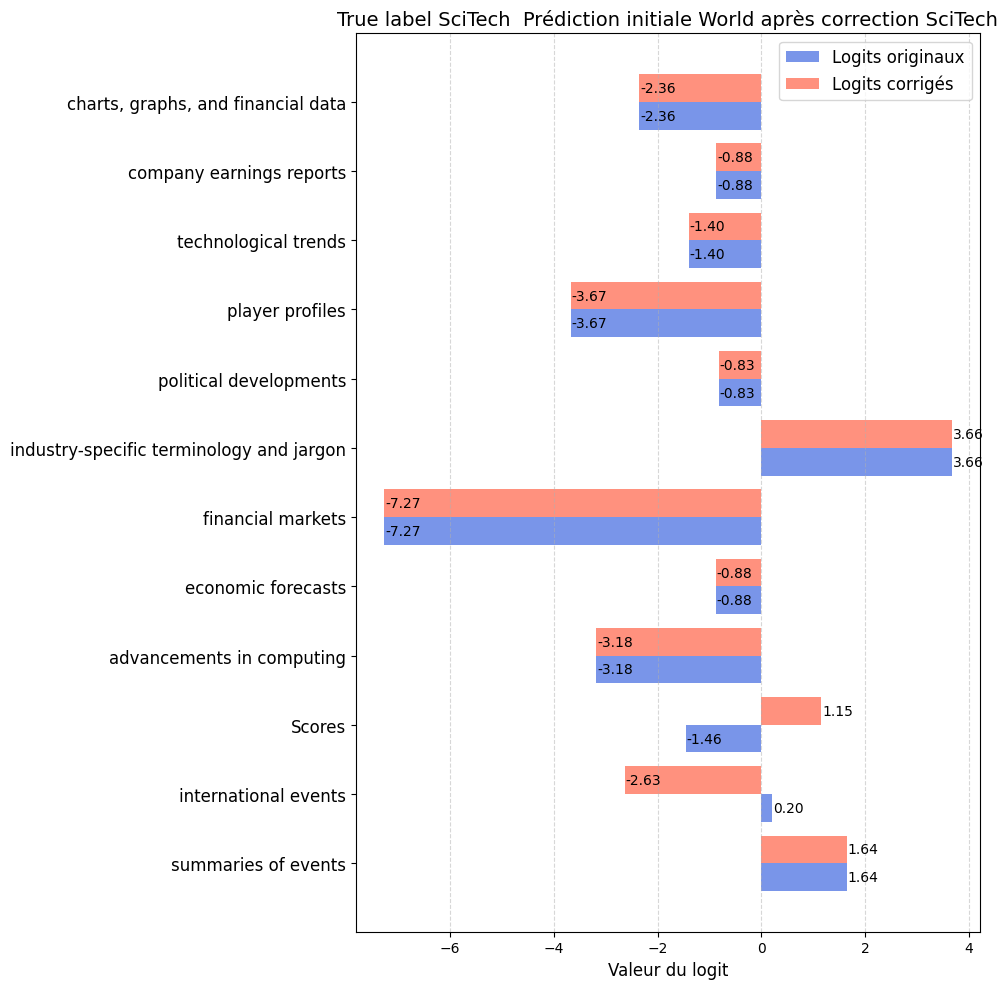

Correction réussie ! Prédiction initiale: 0, Prédiction corrigée: 3
concept predictions vs true concepts
[('summaries of events', 0, 1), ('international events', 1, 0), ('Scores', 1, 0), ('advancements in computing', 0, 1), ('economic forecasts', 0, 0), ('financial markets', 1, 1), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 0), ('player profiles', 0, 0), ('technological trends', 1, 1), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 1, 0)]
concept 3 switched from 0(-3.1839332580566406) to 1(2.0327937602996826)
concept 11 switched from 1(1.817516803741455) to 0(-3.90594482421875)
concept 0 switched from 0(-1.276503086090088) to 1(7.506682395935059)
concept 1 switched from 1(0.5832093358039856) to 0(-2.6331660747528076)
concept 2 switched from 1(0.6877061128616333) to 0(-2.004336357116699)
Correction échouée ! Prédiction initiale: 2, Prédiction corrigée: 1
concept predictions vs true concepts
[('summaries of events', 0, 1)

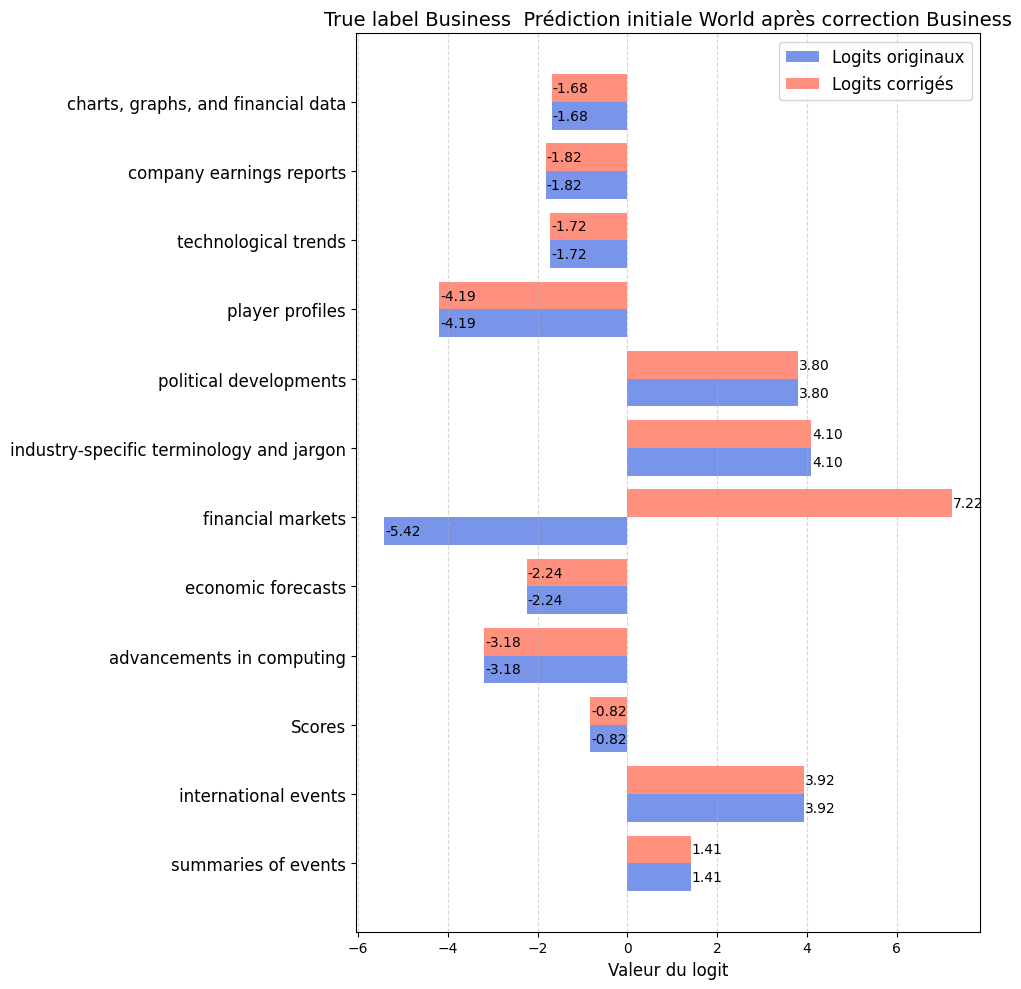

Correction réussie ! Prédiction initiale: 0, Prédiction corrigée: 2
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 1, 1), ('Scores', 0, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0, 0), ('industry-specific terminology and jargon', 1, 0), ('political developments', 1, 1), ('player profiles', 0, 0), ('technological trends', 0, 0), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 0, 0)]
concept 6 switched from 1(3.2538726329803467) to 0(0.0)
Correction échouée ! Prédiction initiale: 0, Prédiction corrigée: 0
concept predictions vs true concepts
[('summaries of events', 0, 1), ('international events', 1, 0), ('Scores', 1, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 1, 0), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 1), ('player profiles', 1, 0), ('technological trends', 1, 1), ('comp

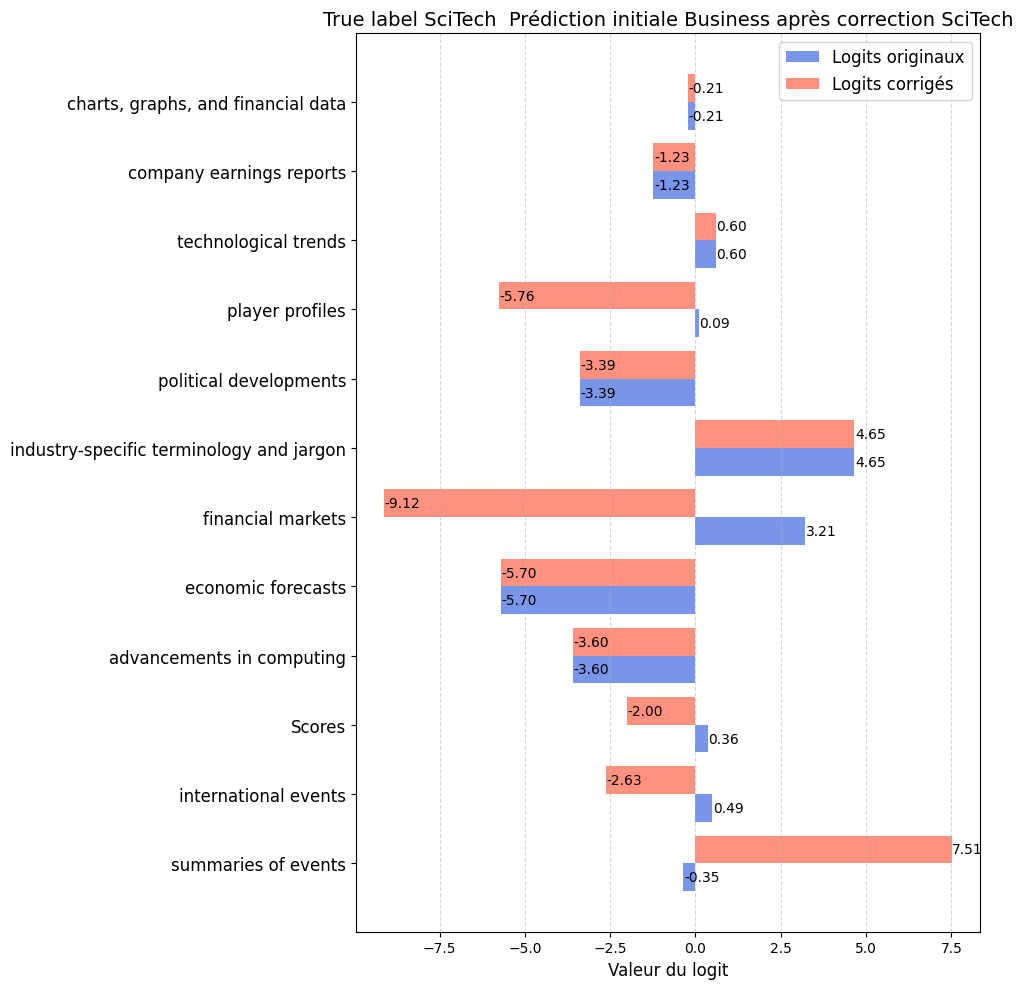

Correction réussie ! Prédiction initiale: 2, Prédiction corrigée: 3
concept predictions vs true concepts
[('summaries of events', 0, 1), ('international events', 1, 0), ('Scores', 0, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 1, 1), ('industry-specific terminology and jargon', 1, 1), ('political developments', 1, 0), ('player profiles', 0, 1), ('technological trends', 0, 0), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 1, 0)]
concept 8 switched from 0(-2.3223774433135986) to 1(0.29825520515441895)
concept 0 switched from 0(-0.6041752099990845) to 1(7.506682395935059)
concept 7 switched from 1(2.326751470565796) to 0(-8.77308177947998)
concept 11 switched from 1(0.7525269389152527) to 0(-3.90594482421875)
concept 1 switched from 1(1.9321070909500122) to 0(-2.6331660747528076)


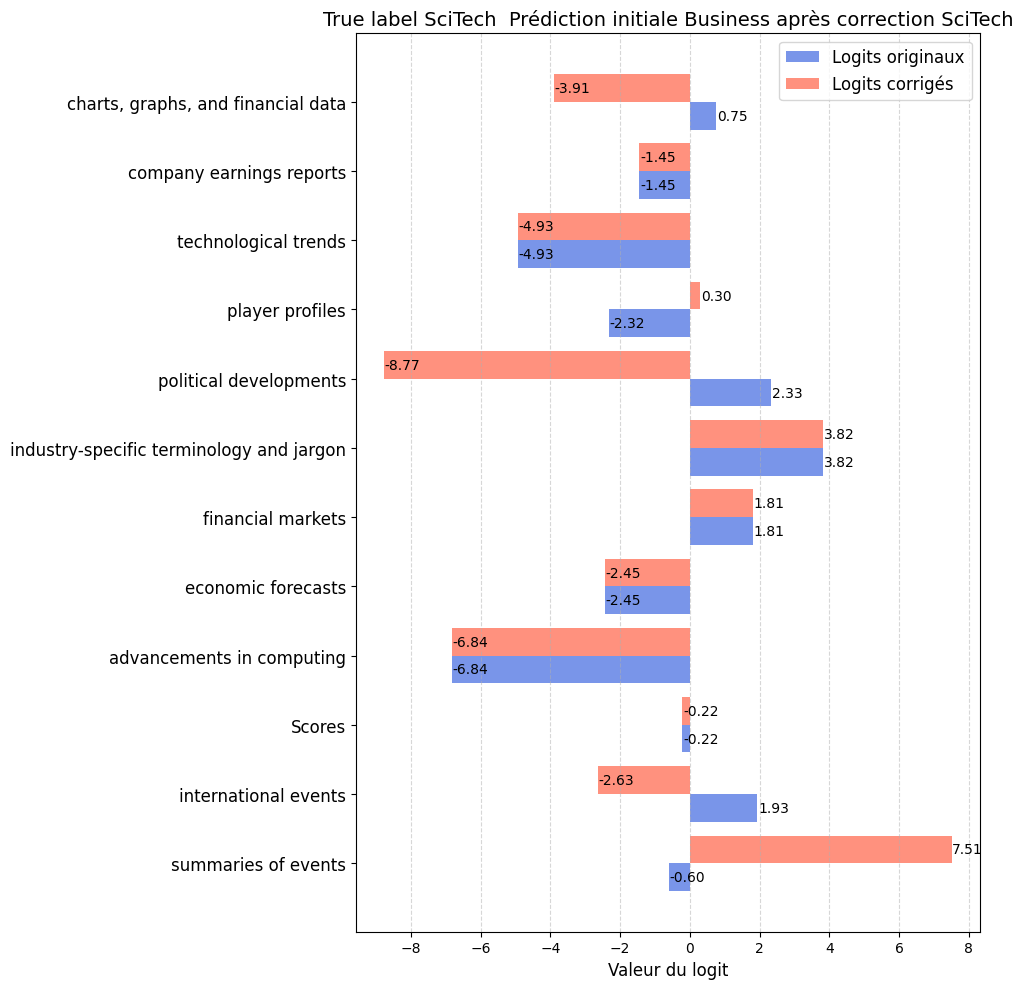

Correction réussie ! Prédiction initiale: 2, Prédiction corrigée: 3
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 1, 1), ('Scores', 0, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0, 0), ('industry-specific terminology and jargon', 1, 1), ('political developments', 1, 0), ('player profiles', 0, 0), ('technological trends', 0, 0), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 0, 0)]
concept 7 switched from 1(4.235820293426514) to 0(-8.77308177947998)
Correction échouée ! Prédiction initiale: 0, Prédiction corrigée: 3
concept predictions vs true concepts
[('summaries of events', 0, 1), ('international events', 0, 0), ('Scores', 1, 0), ('advancements in computing', 0, 1), ('economic forecasts', 0, 1), ('financial markets', 1, 1), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 0), ('player profiles', 0, 0), ('technological trends', 

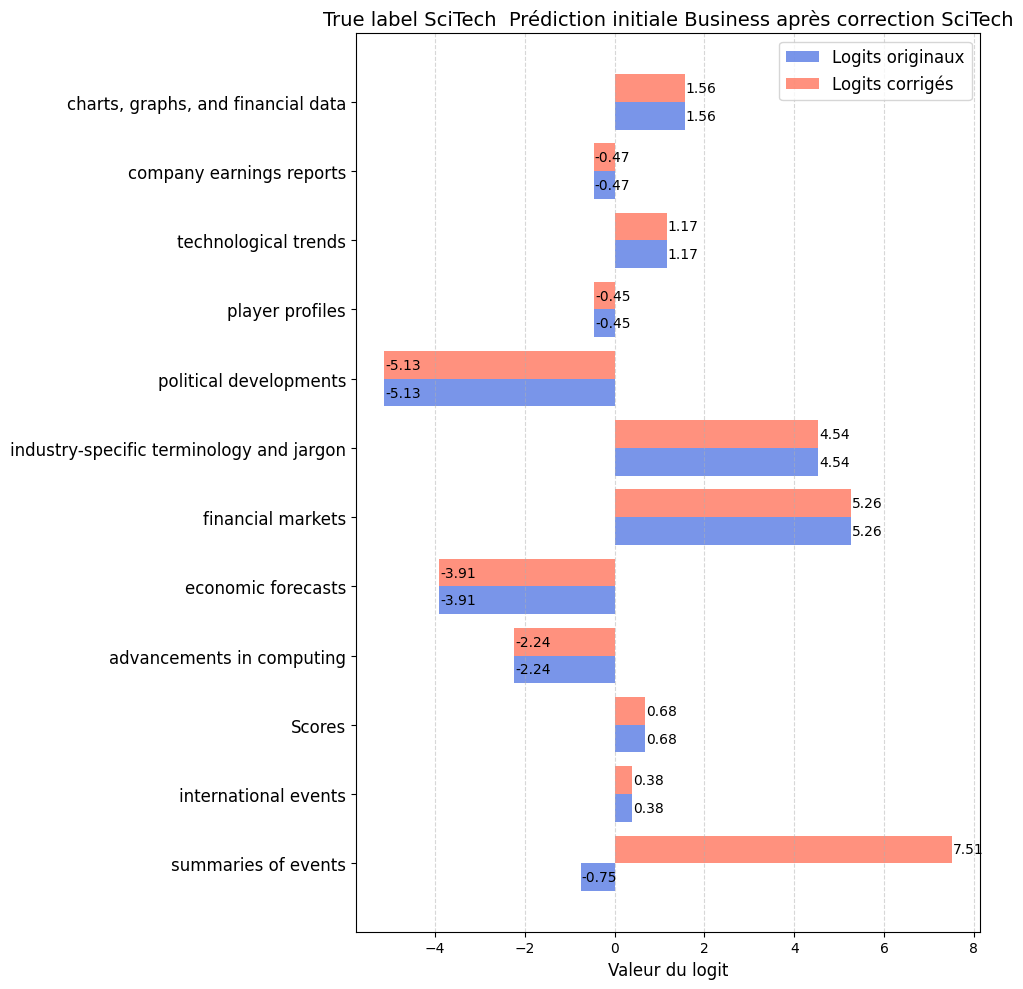

Correction réussie ! Prédiction initiale: 2, Prédiction corrigée: 3
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 1, 1), ('Scores', 0, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 1), ('financial markets', 0, 1), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 0), ('player profiles', 0, 0), ('technological trends', 0, 0), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 0, 0)]
concept 5 switched from 0(-5.387335777282715) to 1(7.219388961791992)
concept 4 switched from 0(-1.1142076253890991) to 1(0.27220168709754944)


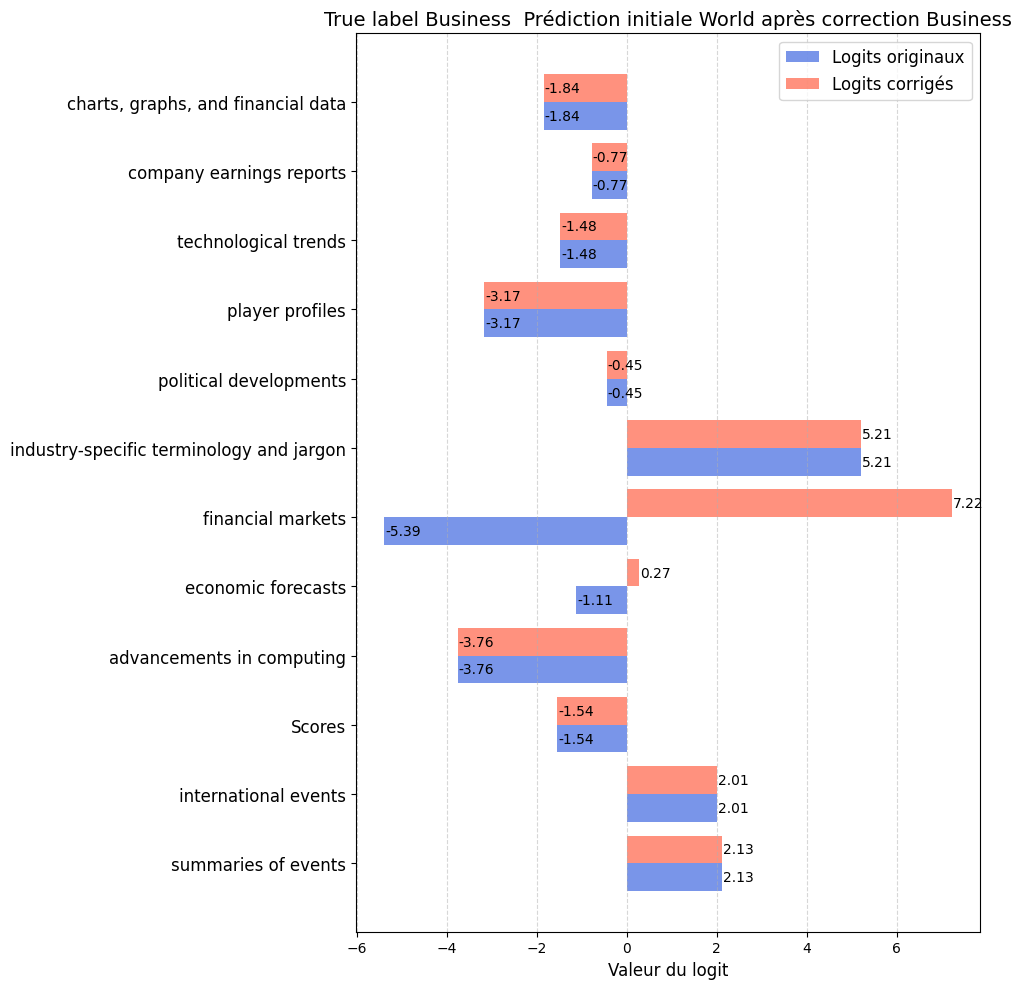

Correction réussie ! Prédiction initiale: 0, Prédiction corrigée: 2
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 1, 1), ('Scores', 0, 1), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0, 0), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 1), ('player profiles', 0, 0), ('technological trends', 0, 0), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 0, 0)]
concept 7 switched from 0(-1.0620219707489014) to 1(5.927428245544434)
concept 2 switched from 0(-0.3091852366924286) to 1(1.1539427042007446)
Correction échouée ! Prédiction initiale: 1, Prédiction corrigée: 1
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 0, 0), ('Scores', 0, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0, 1), ('industry-specific terminology and jargon', 1, 1), ('political 

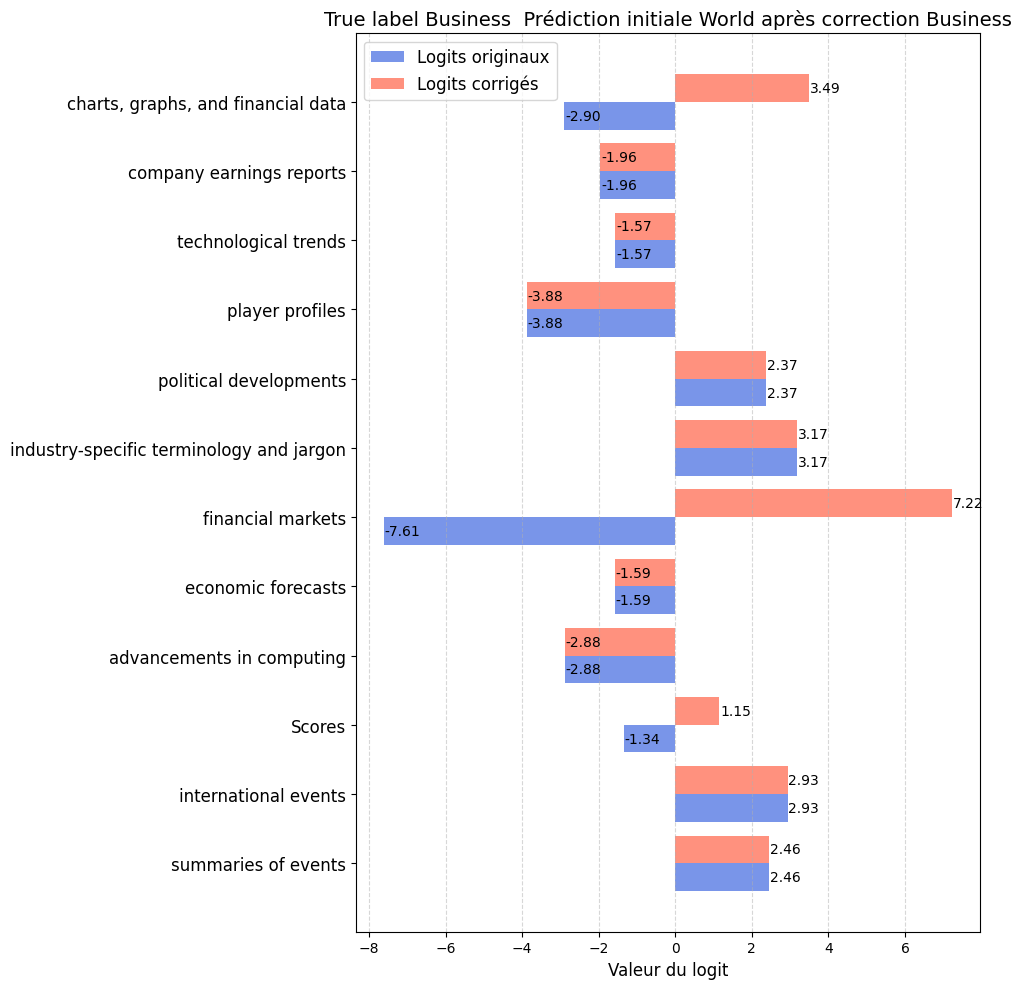

Correction réussie ! Prédiction initiale: 0, Prédiction corrigée: 2
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 1, 1), ('Scores', 0, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0, 0), ('industry-specific terminology and jargon', 1, 1), ('political developments', 1, 1), ('player profiles', 0, 0), ('technological trends', 0, 0), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 0, 1)]
concept 11 switched from 0(-1.889925241470337) to 1(3.4891960620880127)
Correction échouée ! Prédiction initiale: 0, Prédiction corrigée: 0
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 1, 1), ('Scores', 0, 1), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0, 0), ('industry-specific terminology and jargon', 1, 1), ('political developments', 1, 0), ('player profiles', 0, 1), ('technological trends

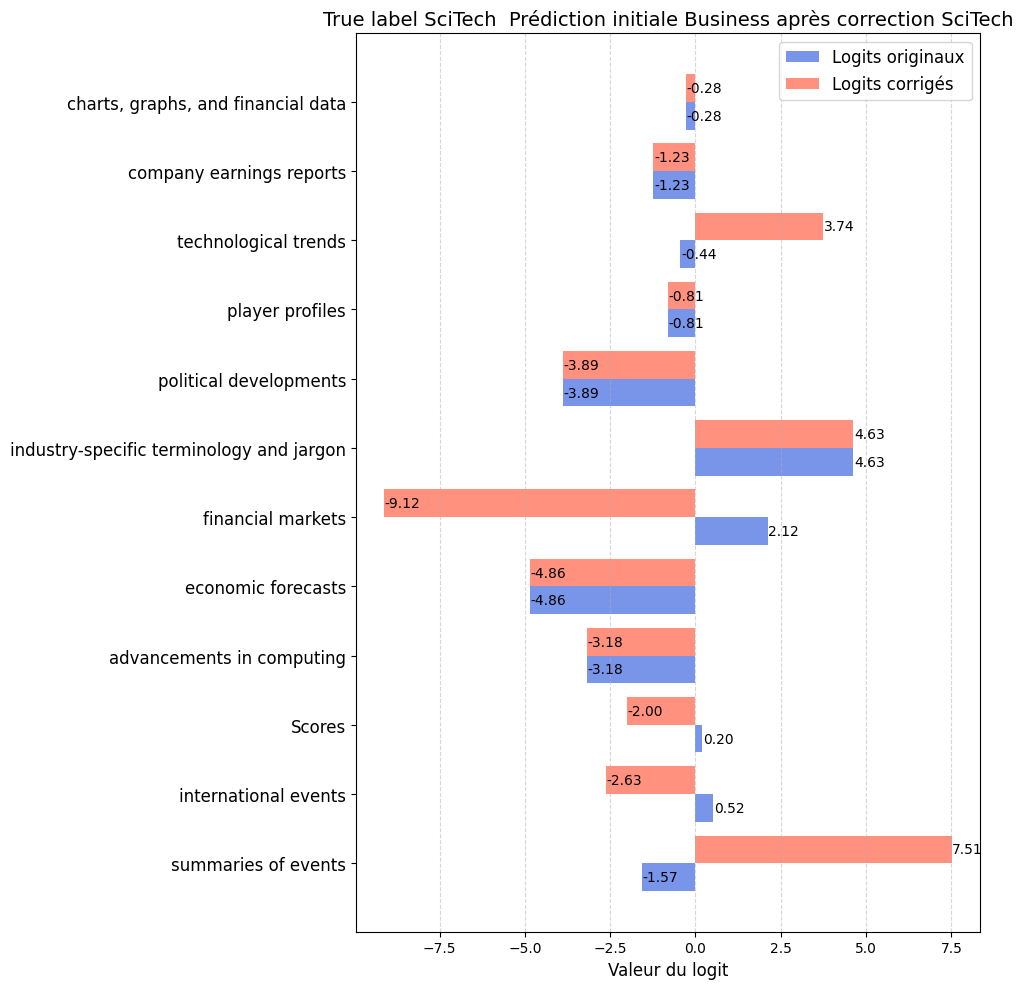

Correction réussie ! Prédiction initiale: 2, Prédiction corrigée: 3
concept predictions vs true concepts
[('summaries of events', 0, 1), ('international events', 1, 1), ('Scores', 0, 0), ('advancements in computing', 0, 1), ('economic forecasts', 0, 0), ('financial markets', 1, 1), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 0), ('player profiles', 0, 0), ('technological trends', 0, 1), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 1, 1)]
concept 0 switched from 0(-0.11717227101325989) to 1(7.506682395935059)
concept 9 switched from 0(-1.314859390258789) to 1(3.737168312072754)
concept 3 switched from 0(-4.439664840698242) to 1(2.0327937602996826)
Correction échouée ! Prédiction initiale: 2, Prédiction corrigée: 1
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 1, 1), ('Scores', 0, 1), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0

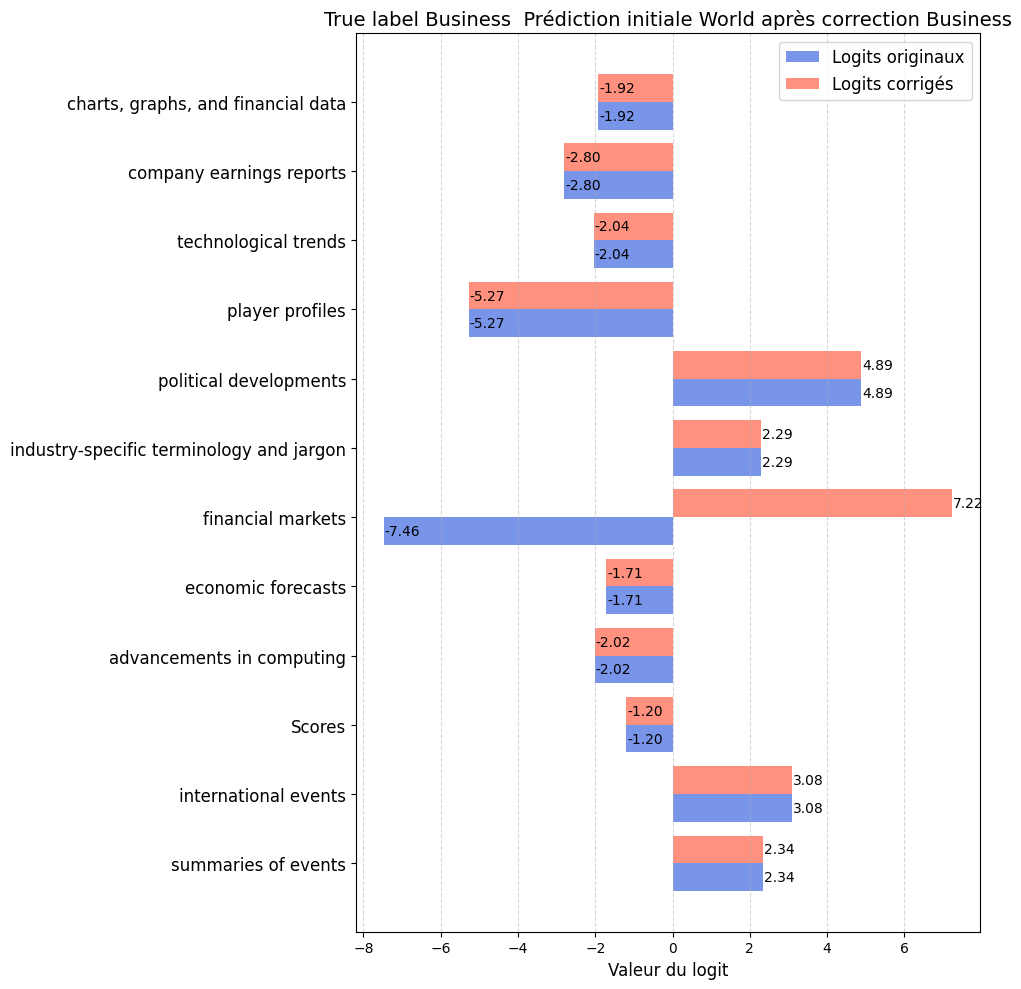

Correction réussie ! Prédiction initiale: 0, Prédiction corrigée: 2
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 1, 1), ('Scores', 0, 0), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 0, 1), ('industry-specific terminology and jargon', 1, 1), ('political developments', 1, 1), ('player profiles', 0, 1), ('technological trends', 0, 0), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 0, 0)]
concept 5 switched from 0(-4.673308372497559) to 1(7.219388961791992)
concept 8 switched from 0(-4.835366725921631) to 1(0.29825520515441895)


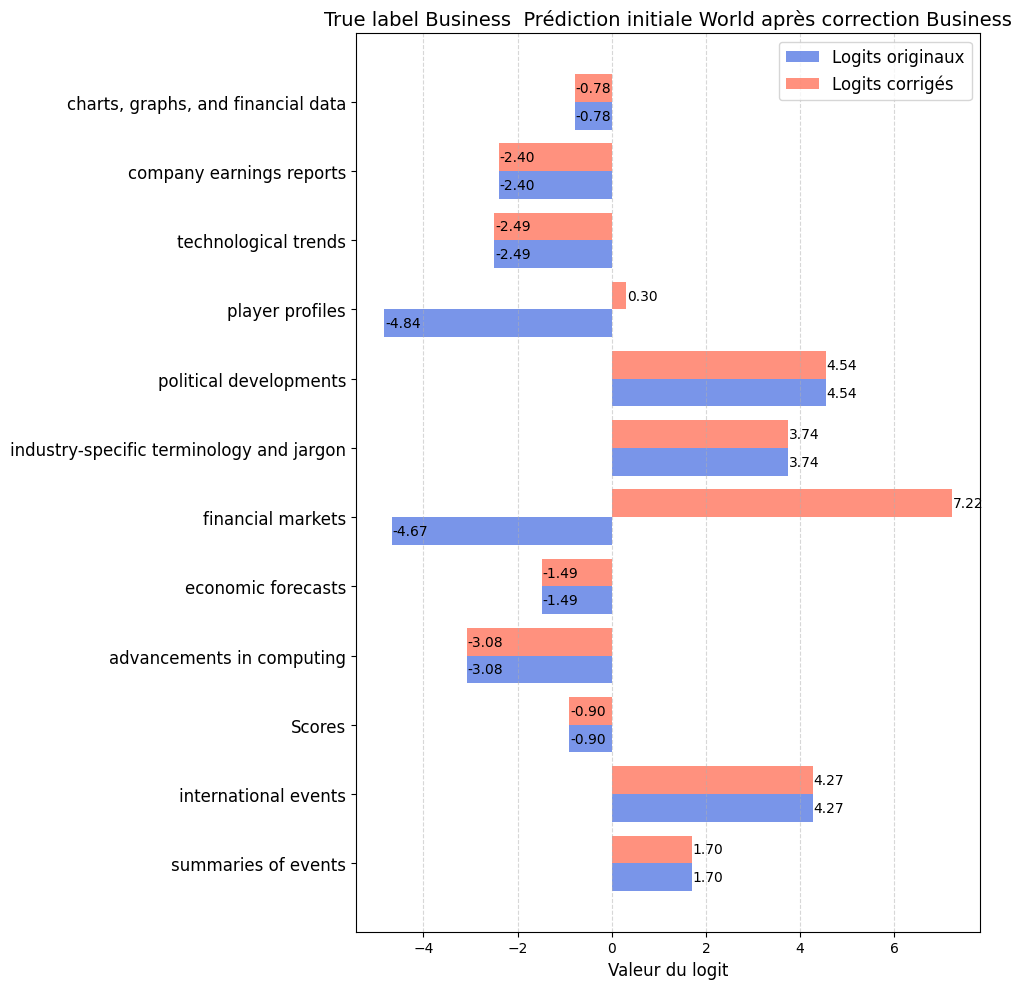

Correction réussie ! Prédiction initiale: 0, Prédiction corrigée: 2
concept predictions vs true concepts
[('summaries of events', 1, 1), ('international events', 1, 1), ('Scores', 1, 1), ('advancements in computing', 0, 0), ('economic forecasts', 0, 0), ('financial markets', 1, 1), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 0), ('player profiles', 0, 0), ('technological trends', 0, 0), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 1, 1)]
Correction échouée ! Prédiction initiale: 2, Prédiction corrigée: 2
concept predictions vs true concepts
[('summaries of events', 0, 1), ('international events', 1, 0), ('Scores', 1, 0), ('advancements in computing', 0, 1), ('economic forecasts', 0, 0), ('financial markets', 1, 1), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 0), ('player profiles', 0, 0), ('technological trends', 1, 1), ('company earnings reports', 0, 0), ('charts, graphs, and fina

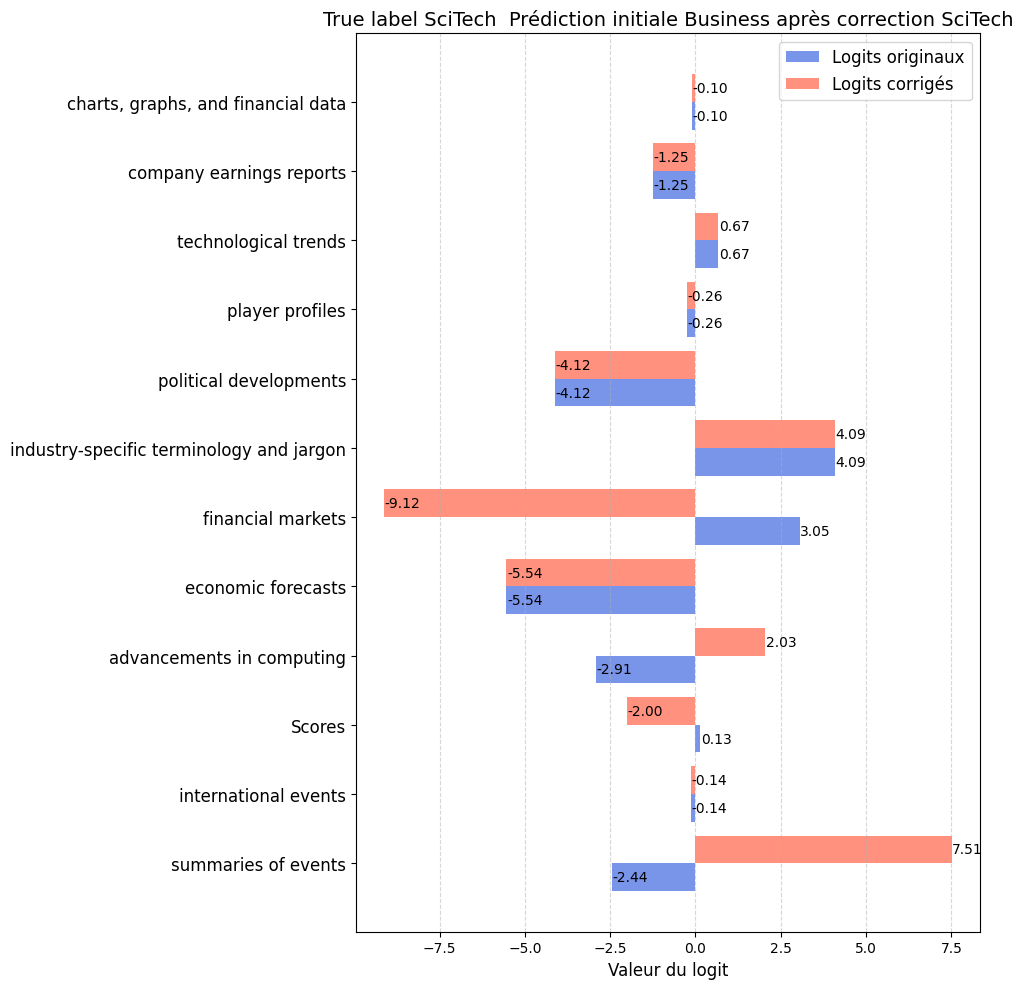

Correction réussie ! Prédiction initiale: 2, Prédiction corrigée: 3
concept predictions vs true concepts
[('summaries of events', 0, 1), ('international events', 1, 0), ('Scores', 1, 0), ('advancements in computing', 0, 1), ('economic forecasts', 0, 0), ('financial markets', 1, 1), ('industry-specific terminology and jargon', 1, 1), ('political developments', 0, 0), ('player profiles', 0, 0), ('technological trends', 1, 1), ('company earnings reports', 0, 0), ('charts, graphs, and financial data', 1, 1)]
concept 2 switched from 1(0.5971391201019287) to 0(-2.004336357116699)
concept 0 switched from 0(-1.0655180215835571) to 1(7.506682395935059)
concept 1 switched from 1(0.13132965564727783) to 0(-2.6331660747528076)
concept 3 switched from 0(-2.0234310626983643) to 1(2.0327937602996826)
Correction échouée ! Prédiction initiale: 2, Prédiction corrigée: 1
concept predictions vs true concepts
[('summaries of events', 0, 1), ('international events', 0, 0), ('Scores', 1, 0), ('advancements i

(0, 15, 104, 0, 15, 0)

In [63]:
concept_correction(CBM_joint, misclassified_examples, minmaxconcepts, n_success_max=5)